# ***Prediction of Energy Consumption in Buildings***

IMPORTING PACKAGES

In [ ]:
import pydot
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

LOADING DATASET

In [ ]:
df1 = pd.read_csv('/content/ListingofBuildingEnergyPerformanceData2020.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 23 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   buildingname                               492 non-null    object 
 1   buildingaddress                            564 non-null    object 
 2   buildingtype                               564 non-null    object 
 3   mainbuildingfunction                       564 non-null    object 
 4   buildingsize                               563 non-null    object 
 5   yearobtainedtopcsc                         564 non-null    int64  
 6   greenmarkrating                            317 non-null    object 
 7   greenmarkyearofaward                       317 non-null    float64
 8   greenmarkversion                           295 non-null    object 
 9   grossfloorarea                             564 non-null    object 
 10  percentageofairconditioned

In [ ]:
df2 = pd.read_csv('/content/ListingofBuildingEnergyPerformanceDataforCommercialBuildings.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   buildingname            783 non-null    object 
 1   buildingaddress         986 non-null    object 
 2   buildingtype            1244 non-null   object 
 3   greenmarkstatus         1244 non-null   object 
 4   greenmarkrating         306 non-null    object 
 5   greenmarkyearaward      306 non-null    float64
 6   buildingsize            1189 non-null   object 
 7   grossfloorarea          986 non-null    object 
 8   2017energyuseintensity  1224 non-null   float64
 9   2018energyusintensity   1224 non-null   float64
 10  voluntarydisclosure     1244 non-null   object 
dtypes: float64(3), object(8)
memory usage: 107.0+ KB


In [ ]:
df1 = df1.drop(['buildingtype', 'buildingsize'], axis = 1)
df2 = df2[['buildingname', 'greenmarkstatus', 'buildingsize']]

In [ ]:
df2_unique = df2.drop_duplicates(subset='buildingname')
df2_indexed = df2_unique.set_index('buildingname')

df1['greenmarkstatus'] = df1['buildingname'].map(df2_indexed['greenmarkstatus'])
df1['buildingsize'] = df1['buildingname'].map(df2_indexed['buildingsize'])

In [ ]:
df = df1.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 23 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   buildingname                               492 non-null    object 
 1   buildingaddress                            564 non-null    object 
 2   mainbuildingfunction                       564 non-null    object 
 3   yearobtainedtopcsc                         564 non-null    int64  
 4   greenmarkrating                            317 non-null    object 
 5   greenmarkyearofaward                       317 non-null    float64
 6   greenmarkversion                           295 non-null    object 
 7   grossfloorarea                             564 non-null    object 
 8   percentageofairconditionedfloorarea        564 non-null    object 
 9   averagemonthlybuildingoccupancyrate        564 non-null    object 
 10  numberofhotelrooms        

DATA PRE PROCESSING

In [ ]:
columns = ['mainbuildingfunction', 'buildingsize',
           'greenmarkrating', 'greenmarkstatus', 'installationofsolarpv']

for column in columns:
    if df[column].dtype == 'object':
        print(f"Unique values in '{column}':")
        print(df[column].unique())
        print("\n" + "-"*50 + "\n")


Unique values in 'mainbuildingfunction':
['Mixed Development' 'Office' 'Retail' 'Hotel']

--------------------------------------------------

Unique values in 'buildingsize':
['Large' 'Small' nan]

--------------------------------------------------

Unique values in 'greenmarkrating':
[nan 'GoldPlus' 'Platinum' 'Gold' 'Certified' 'Legislated']

--------------------------------------------------

Unique values in 'greenmarkstatus':
['No' 'Yes' nan]

--------------------------------------------------

Unique values in 'installationofsolarpv':
['N' 'Y']

--------------------------------------------------



In [ ]:
df = df.drop(['buildingname', 'greenmarkversion', 'greenmarkyearofaward',
              'numberofhotelrooms', 'centralisedairconditioningplantefficiency',
              'yearoflastchillerplantaudithealthcheck', ], axis = 1).reset_index(drop = True)

In [ ]:
df = df.dropna(
    subset = [
        'buildingaddress', 'buildingsize', 'greenmarkrating',
        '2017', '2018', '2019', '2020', 'ageofchiller',
    ]
).reset_index(drop = True)

In [ ]:
df['grossfloorarea'] = df['grossfloorarea'].str.replace(',','').astype(int)
df['percentageusageofled'] = df['percentageusageofled'].str.replace('%', '').astype(float)
df['percentageofairconditionedfloorarea'] = df['percentageofairconditionedfloorarea'].str.replace('%', '').astype(float)
df['averagemonthlybuildingoccupancyrate'] = df['averagemonthlybuildingoccupancyrate'].str.replace('%', '').astype(float)

In [ ]:
print(df.isna().sum())
print("\n" + "-"*50 + "\n")
print(df.info())

buildingaddress                        0
mainbuildingfunction                   0
yearobtainedtopcsc                     0
greenmarkrating                        0
grossfloorarea                         0
percentageofairconditionedfloorarea    0
averagemonthlybuildingoccupancyrate    0
typeofairconditioningsystem            0
ageofchiller                           0
percentageusageofled                   0
installationofsolarpv                  0
2017                                   0
2018                                   0
2019                                   0
2020                                   0
greenmarkstatus                        0
buildingsize                           0
dtype: int64

--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  


EXPLORATORY DATA ANALYSIS

---



In [ ]:
color_2_types = ['DarkGray','LawnGreen']
color_rating = dict(
    Certified = 'DarkGreen', Legislated = 'Red', Gold = 'Gold',
    GoldPlus = 'DarkGoldenRod', NotCertified = 'Black', Platinum = '#e5e4e2'
)

def newLegend(fig, newNames):
    for item in newNames:
        for i, elem in enumerate(fig.data[0].labels):
            if elem == item:
                fig.data[0].labels[i] = newNames[item]
    return(fig)

fig = px.pie(
    df,
    names = 'greenmarkstatus',
    color_discrete_sequence = color_2_types,
    title = 'Composition Green Building in Singapore',
)

fig.update_traces(
    textposition = 'inside',
    textinfo = 'percent+label+value',
    textfont_size = 16,
    showlegend = False,
)

fig = newLegend(
  fig = fig,
  newNames = dict(
      No = 'Normal Building',
      Yes='Green Building',
  )
)
fig.show()

In [ ]:
df['averageEUI'] = df[['2017', '2018', '2019', '2020']].mean(axis=1)

fig = px.box(
    df,
    x = 'greenmarkrating',
    y = 'averageEUI',
    title = 'Box Plot of Average EUI by Green Mark Rating'
)

fig.update_layout(width = 800, height = 600)
fig.show()

df = df.drop(columns = ['averageEUI'], axis = 1)

In [ ]:
size_counts = df['buildingsize'].value_counts().reset_index()
size_counts.columns = ['buildingsize', 'Count']
fig = px.pie(size_counts, values='Count', names='buildingsize', title='Distribution of Building Sizes')
fig.show()

In [ ]:
count_df = df.groupby(['mainbuildingfunction', 'buildingsize']).size().reset_index(name = 'Count')
fig = px.bar(count_df,
             x = 'mainbuildingfunction',
             y = 'Count',
             color = 'buildingsize',
             title = 'Stacked Bar Chart of Building Type based on different Building Sizes',
             text = 'Count',
             barmode = 'overlay')
fig.show()

In [ ]:
tree_data = df[df['greenmarkstatus'] == 'Yes'].groupby(['greenmarkrating','mainbuildingfunction']).count().reset_index()

fig = px.treemap(
    tree_data,
    path = ['greenmarkrating', 'mainbuildingfunction'],
    values = 'greenmarkstatus',
    color = 'greenmarkrating',
    color_discrete_map = color_rating,
    title = 'Rating Wise Green Building'
)

fig.update_layout(
    uniformtext_minsize=14,
    uniformtext_mode='hide',
)

fig.show()

PRE-PROCESSING FOR MODEL BUILDING


In [ ]:
data = df.copy()
data = data.drop(columns = ['buildingaddress', 'yearobtainedtopcsc'], axis = 1)

In [ ]:
data['averageEUI'] = data[['2017', '2018', '2019']].mean(axis = 1)

In [ ]:
for index, row in data.iterrows():
    if row['mainbuildingfunction'] == 'Office':
        threshold = 216
    elif row['mainbuildingfunction'] == 'Hotel':
        threshold = 292
    elif row['mainbuildingfunction'] == 'Retail':
        threshold = 405
    elif row['mainbuildingfunction'] == 'Mixed Development':
        threshold = 264
    else:
        continue  # Skip rows that don't match any category

    # Assign 'High' or 'Low' based on the threshold
    data.at[index, 'EUI'] = "High" if row['2020'] >= threshold else "Low"


In [ ]:
# # Apply High/Low categorization based on `mainbuildingfunction` and `2020` column values
# data.loc[(data['mainbuildingfunction'] == 'Office') & (data['2020'] >= 216), 'EUI_20'] = "High"
# data.loc[(data['mainbuildingfunction'] == 'Office') & (data['2020'] < 216), 'EUI_20'] = "Low"

# data.loc[(data['mainbuildingfunction'] == 'Hotel') & (data['2020'] >= 292), 'EUI_20'] = "High"
# data.loc[(data['mainbuildingfunction'] == 'Hotel') & (data['2020'] < 292), 'EUI_20'] = "Low"

# data.loc[(data['mainbuildingfunction'] == 'Retail') & (data['2020'] >= 405), 'EUI_20'] = "High"
# data.loc[(data['mainbuildingfunction'] == 'Retail') & (data['2020'] < 405), 'EUI_20'] = "Low"

# data.loc[(data['mainbuildingfunction'] == 'Mixed Development') & (data['2020'] >= 264), 'EUI_20'] = "High"
# data.loc[(data['mainbuildingfunction'] == 'Mixed Development') & (data['2020'] < 264), 'EUI_20'] = "Low"


In [ ]:
# data.loc[data[data['2017'] >= 260].index, 'EUI_17'] = "High"
# data.loc[data[data['2017'] < 260].index, 'EUI_17'] = "Low"

# data.loc[data[data['2018'] >= 260].index, 'EUI_18'] = "High"
# data.loc[data[data['2018'] < 260].index, 'EUI_18'] = "Low"

# data.loc[data[data['2019'] >= 260].index, 'EUI_19'] = "High"
# data.loc[data[data['2019'] < 260].index, 'EUI_19'] = "Low"

# data.loc[data[data['2020'] >= 260].index, 'EUI_20'] = "High"
# data.loc[data[data['2020'] < 260].index, 'EUI_20'] = "Low"

In [ ]:
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical feature
for column in data.columns:
  if data[column].dtype == 'object':
    data[column] = label_encoder.fit_transform(data[column])

MODEL TRAIN TEST

In [ ]:
X = data.drop(['2017', '2018', '2019', '2020', 'EUI'], axis = 1)
y = data['EUI']

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = None)
print(f'data: {data.shape}')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

data: (241, 17)
X_train: (192, 12), y_train: (192,)
X_test: (49, 12), y_test: (49,)


DECISION TREE

In [ ]:
DT = DecisionTreeClassifier(
    random_state = None,
    criterion = 'gini'
)
DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
# Predictions and Evaluation
y_pred = DT.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.7959183673469388
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.68      0.75        22
           1       0.77      0.89      0.83        27

    accuracy                           0.80        49
   macro avg       0.80      0.79      0.79        49
weighted avg       0.80      0.80      0.79        49



In [ ]:
# Feature Importance
importances = DT.feature_importances_
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(by = "Importance", ascending = False)
print("Feature Importance:\n", feature_importance)

Feature Importance:
                                 Feature  Importance
11                           averageEUI    0.501754
2                        grossfloorarea    0.190262
0                  mainbuildingfunction    0.154982
6                          ageofchiller    0.048290
3   percentageofairconditionedfloorarea    0.043334
1                       greenmarkrating    0.022319
4   averagemonthlybuildingoccupancyrate    0.022319
7                  percentageusageofled    0.016739
5           typeofairconditioningsystem    0.000000
8                 installationofsolarpv    0.000000
9                       greenmarkstatus    0.000000
10                         buildingsize    0.000000


RANDOM FOREST

In [ ]:
# Defining parameter for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
# Initialize RandomForestClassifier
RF = RandomForestClassifier(random_state = 42)

In [ ]:
# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator = RF,
    param_grid = param_grid,
    cv = 5,  # 5-fold cross-validation
    scoring = 'accuracy',
    n_jobs=-1,  # Use all available cores
    verbose = 2
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [ ]:
# Get the best parameters and the best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.8750337381916328


In [ ]:
# Use the best estimator from the grid search to make predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.7959183673469388
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.65      0.69        17
           1       0.82      0.88      0.85        32

    accuracy                           0.80        49
   macro avg       0.78      0.76      0.77        49
weighted avg       0.79      0.80      0.79        49



PLOTING GRAPH

In [ ]:
RFModel = RandomForestClassifier(
    random_state = 42,
    n_estimators = 200,
    criterion = 'gini',
    max_depth = None,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = 'sqrt'
)
RFModel.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
tree = RFModel.estimators_[4]

export_graphviz(
    tree,
    out_file = 'tree.dot',
    feature_names = list(X.columns),
    class_names = ['No','Yes'] ,
    rounded = True,
    filled = True
)

(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

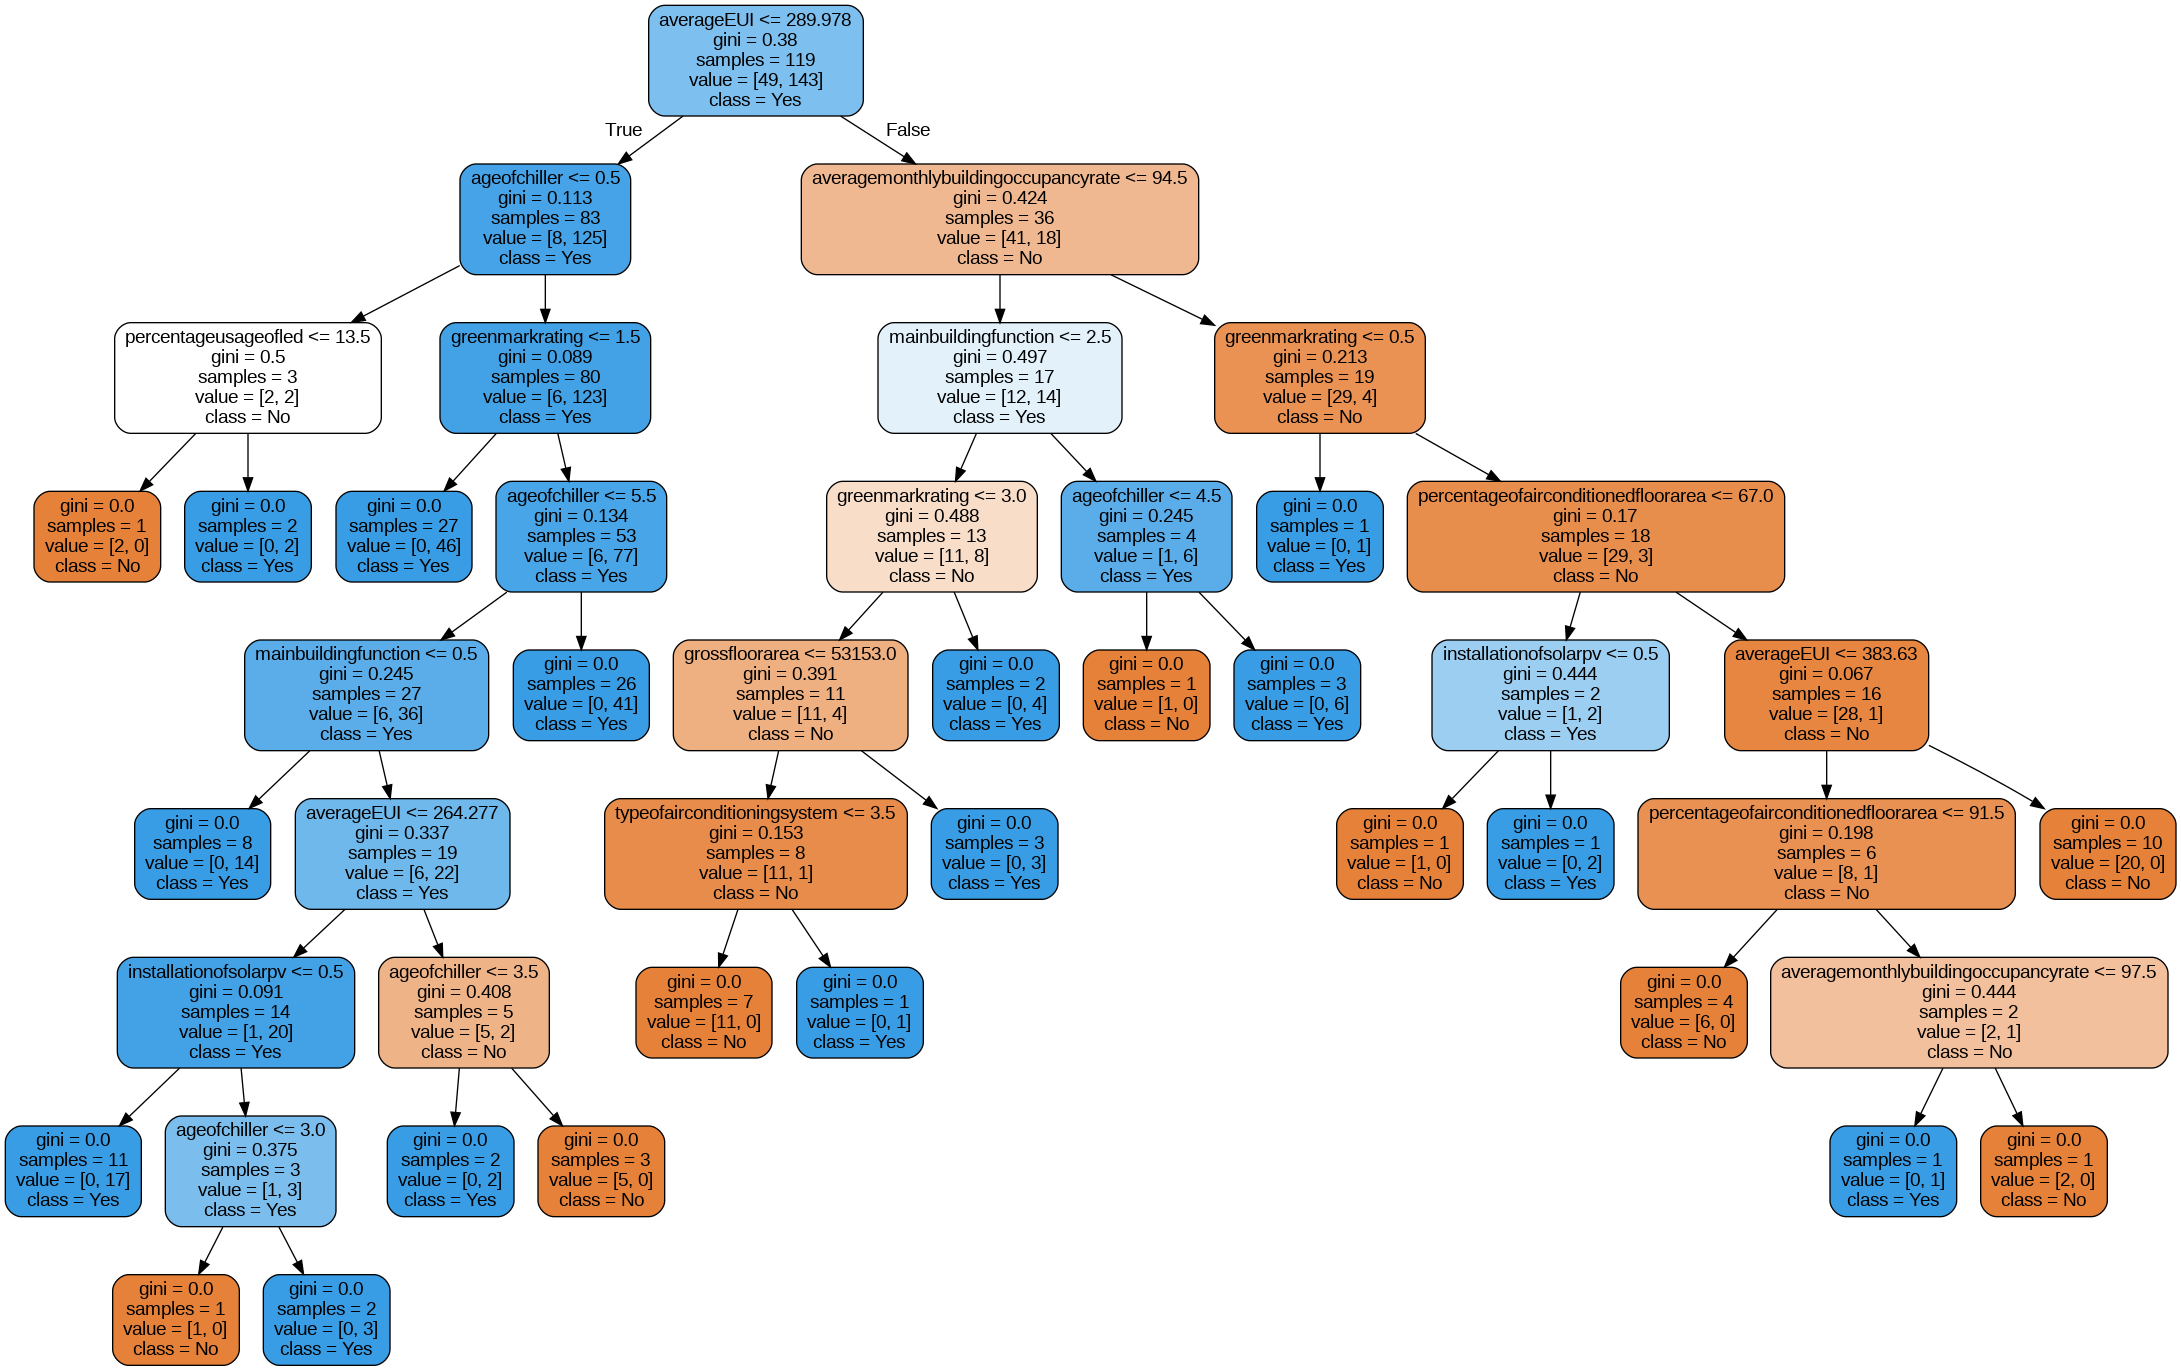

In [ ]:
from IPython.display import Image
Image(filename = 'tree.png')

EXPORTING MODEL

In [ ]:
pickle.dump(RFModel, open('Energy_Comsumption.pkl','wb'))


# ***TESTING WITH MODEL***
---



IMPORTING CSV

In [ ]:
test = pd.read_csv('/content/testdata.csv')

In [ ]:
print(test.isna().sum())
print("\n" + "-"*50 + "\n")
print(test.info())

Building Address                       0
Main Building Function                 0
Year Obtained Top CSC                  0
Green Mark Rating                      0
Green Mark Version                     0
Gross Floor Area                       0
% of Air-Conditioned Floor Area        0
Avg Monthly Building Occupancy Rate    0
Type of Air Conditioning System        0
Age of Chiller                         0
% Usage of LED                         0
Installation of Solar PV               0
2017                                   0
2018                                   0
2019                                   0
2020                                   0
Green Mark Status                      0
Building Size                          0
dtype: int64

--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                 

PRE PROCESSING

In [ ]:
test = test.drop(['Building Address', 'Year Obtained Top CSC', 'Green Mark Version'], axis = 1).reset_index(drop = True)

In [ ]:
test = test.rename(
    columns = {
        'Main Building Function': 'mainbuildingfunction',
        'Green Mark Rating': 'greenmarkrating',
        'Gross Floor Area': 'grossfloorarea',
        'Green Mark Status': 'greenmarkstatus',
        'Installation of Solar PV': 'installationofsolarpv',
        'Age of Chiller': 'ageofchiller',
        '% Usage of LED': 'percentageusageofled',
        '% of Air-Conditioned Floor Area': 'percentageofairconditionedfloorarea',
        'Avg Monthly Building Occupancy Rate': 'averagemonthlybuildingoccupancyrate',
        'Building Size': 'buildingsize',
        'Type of Air Conditioning System': 'typeofairconditioningsystem'
    }
  )


In [ ]:
test['averageEUI'] = test[['2017', '2018', '2019', '2020']].mean(axis = 1)

In [ ]:
for index, row in test.iterrows():
    if row['mainbuildingfunction'] == 'Office':
        threshold = 216
    elif row['mainbuildingfunction'] == 'Hotel':
        threshold = 292
    elif row['mainbuildingfunction'] == 'Retail':
        threshold = 405
    elif row['mainbuildingfunction'] == 'Mixed Development':
        threshold = 264
    else:
        continue  # Skip rows that don't match any category

    # Assign 'High' or 'Low' based on the threshold
    test.at[index, 'EUI'] = "High" if row['averageEUI'] >= threshold else "Low"


In [ ]:
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical feature
for column in test.columns:
  if test[column].dtype == 'object':
    test[column] = label_encoder.fit_transform(test[column])

In [ ]:
y_test = test['EUI']
test = test.drop(['2017', '2018', '2019', '2020', 'EUI'], axis = 1).reset_index(drop = True)

IMPORTING MODEL

In [ ]:
with open('/content/Energy_Comsumption.pkl', 'rb') as file:
    model = pickle.load(file)

In [ ]:
# Predictions and Evaluation
y_pred = model.predict(test)

PREDICTION

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.8
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.80      1.00      0.89         8

    accuracy                           0.80        10
   macro avg       0.40      0.50      0.44        10
weighted avg       0.64      0.80      0.71        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Feature Importance
importances = DT.feature_importances_
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(by = "Importance", ascending = False)
print("Feature Importance:\n", feature_importance)

Feature Importance:
                                 Feature  Importance
11                           averageEUI    0.501754
2                        grossfloorarea    0.190262
0                  mainbuildingfunction    0.154982
6                          ageofchiller    0.048290
3   percentageofairconditionedfloorarea    0.043334
1                       greenmarkrating    0.022319
4   averagemonthlybuildingoccupancyrate    0.022319
7                  percentageusageofled    0.016739
5           typeofairconditioningsystem    0.000000
8                 installationofsolarpv    0.000000
9                       greenmarkstatus    0.000000
10                         buildingsize    0.000000


# ***CONCLUSION***

---




We can say that the Random Forest Model works well for the prediction of Energy Consumption in buildings of Singapore with accuracy of 80%.

The model also highlights the important features. Majorly, averageEUI of past years, Gross floor area and Main builidng function influences the prediction.

# ***RECOMMENDATIONS***

---





**Reduce Average EUI *(0.529)* :** As average EUI is the most important feature, focus on reducing this metric.

This can involve:

* Upgrading to energy-efficient HVAC systems.
* Improving insulation to maintain internal temperatures.
* Adopting energy-saving practices, such as using automation to manage power consumption during non-operational hours.

**Optimize Gross Floor Area *(0.207)* :** Smaller or more efficient space usage can lower energy demand. This could mean: Reducing unused or underutilized spaces. Consolidating operations within an optimized floor plan.

**Consider Building Functionality *(0.116)* :** Aligning the building's function with energy-efficient operations—like installing energy-efficient infrastructure for buildings with high energy demand—can also contribute to reduced energy use.

**Minimize Air-Conditioned Floor Area *(0.106)* :** Reducing the percentage of air-conditioned spaces could contribute to lower energy needs, such as:
Using natural ventilation where possible. Creating zoned HVAC systems that condition only necessary areas.

**Maximize LED Lighting Usage *(0.041)* :** Although lower on the feature importance scale, maximizing LED usage helps reduce energy use in lighting. Expanding LED usage across all possible areas will contribute to overall energy efficiency.